### <span style = "color:#87CEEB"> Projet Maching Learning : Détection de fraude </span>

#### Data Source

**Data set: https://www.kaggle.com/datasets/sgpjesus/bank-account-fraud-dataset-neurips-2022**

### Importation des librairies nécessaires

In [4]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# ML Libraries
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier, VotingClassifier
from sklearn.svm import SVC
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.preprocessing import LabelEncoder
from sklearn.pipeline import Pipeline
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from scipy.stats import zscore


from transformers import pipeline
from transformers import BertTokenizer
import re

## Chargement des données

In [5]:
file_path = r'Base.csv'
df = pd.read_csv(file_path)


In [6]:
df.size

32000000

In [7]:
df.shape


(1000000, 32)

## Data cleaning


In [8]:
# Remplacer les valeurs négatives insignificatives par NaN
exclude_column = ['credit_risk_score','device_os','source','housing_status','employment_status','payment_type']
for col in df.columns:
    if col not in exclude_column:
        df[col] = df[col].apply(lambda x: x if x >= 0 else np.nan)

In [9]:
df.isnull().sum()

fraud_bool                               0
income                                   0
name_email_similarity                    0
prev_address_months_count           712920
current_address_months_count          4254
customer_age                             0
days_since_request                       0
intended_balcon_amount              742523
payment_type                             0
zip_count_4w                             0
velocity_6h                             44
velocity_24h                             0
velocity_4w                              0
bank_branch_count_8w                     0
date_of_birth_distinct_emails_4w         0
employment_status                        0
credit_risk_score                        0
email_is_free                            0
housing_status                           0
phone_home_valid                         0
phone_mobile_valid                       0
bank_months_count                   253635
has_other_cards                          0
proposed_cr

In [10]:
#Suppression de lignes contenant des valeurs manquantes qui n'influance pas le dataset
df = df[~((df['bank_months_count'].isna()) & (df['fraud_bool'] == 0))]

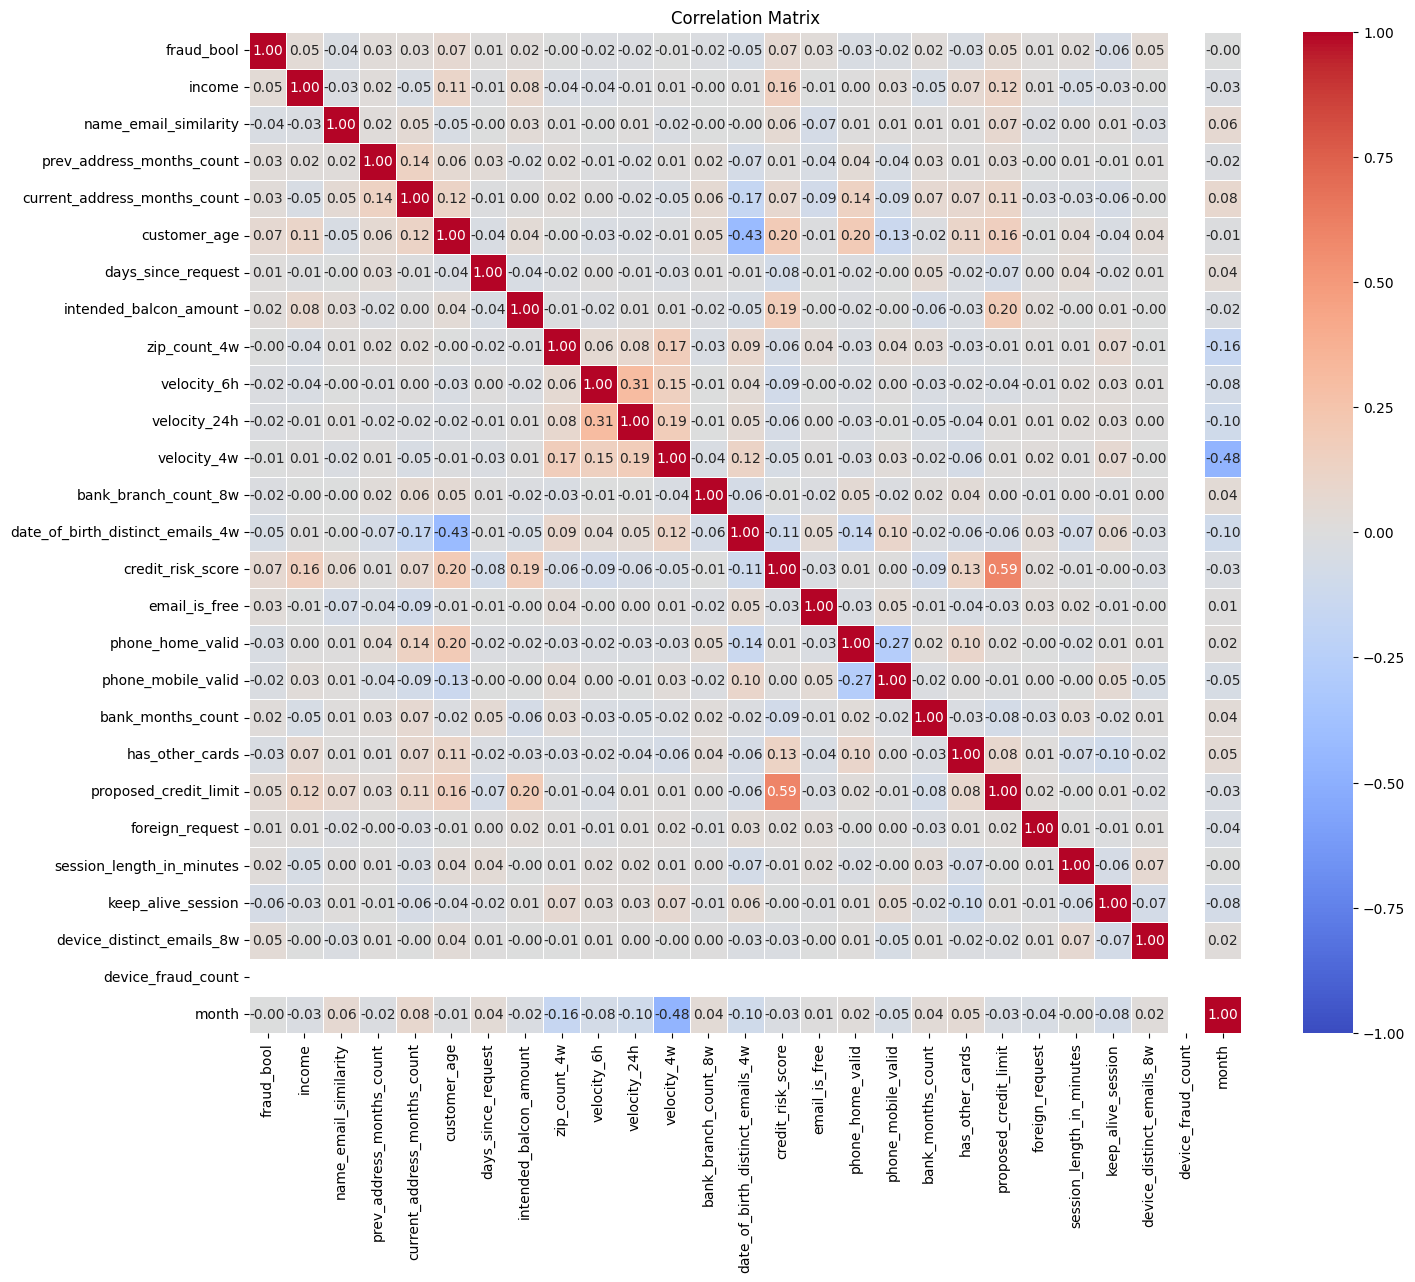

In [9]:
#Matrice de corrélation
numeric_df = df.select_dtypes(include=['number'])
correlation_matrix = numeric_df.corr()
plt.figure(figsize=(16, 13))  # Adjust the size of the plot
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt='.2f', linewidths=0.5, vmin=-1, vmax=1)
plt.title("Correlation Matrix")
plt.show()

On remarque que les deux colonnes 'prev_address_months_count' et 'intended_balcon_amount' ne sont pas foetement corrélées avec les autres colonnes, en plus la majorité de leurs valeurs son manquante, donc on les supprime 

In [11]:
df.drop(columns=['prev_address_months_count','intended_balcon_amount'], inplace=True)

In [12]:
df.isnull().sum()

fraud_bool                             0
income                                 0
name_email_similarity                  0
current_address_months_count        3156
customer_age                           0
days_since_request                     0
payment_type                           0
zip_count_4w                           0
velocity_6h                           42
velocity_24h                           0
velocity_4w                            0
bank_branch_count_8w                   0
date_of_birth_distinct_emails_4w       0
employment_status                      0
credit_risk_score                      0
email_is_free                          0
housing_status                         0
phone_home_valid                       0
phone_mobile_valid                     0
bank_months_count                   4140
has_other_cards                        0
proposed_credit_limit                  0
foreign_request                        0
source                                 0
session_length_i

On supprime les valeurs manquantes de quelques colonnes et qui sont de la classe majoritaire Non fraudulent 

In [7]:
df = df[~((df['session_length_in_minutes'].isna()) & (df['fraud_bool'] == 0))]

In [8]:
df = df[~((df['bank_months_count'].isna()) & (df['fraud_bool'] == 0))]


In [9]:
df = df[~((df['velocity_6h'].isna()) & (df['fraud_bool'] == 0))]

In [10]:
df= df[~((df['device_distinct_emails_8w'].isna()) & (df['fraud_bool'] == 0))]

In [15]:
count=((df['bank_months_count'].isna()) & (df['fraud_bool'] == 1)).sum()
print(count) ##toutes les valeurs nulles correspond a une fraude !

476


In [ ]:
df.isnull().sum()

,0
fraud_bool,0
income,0
name_email_similarity,0
current_address_months_count,3155
customer_age,0
days_since_request,0
payment_type,0
zip_count_4w,0
velocity_6h,0
velocity_24h,0


## Data visualization


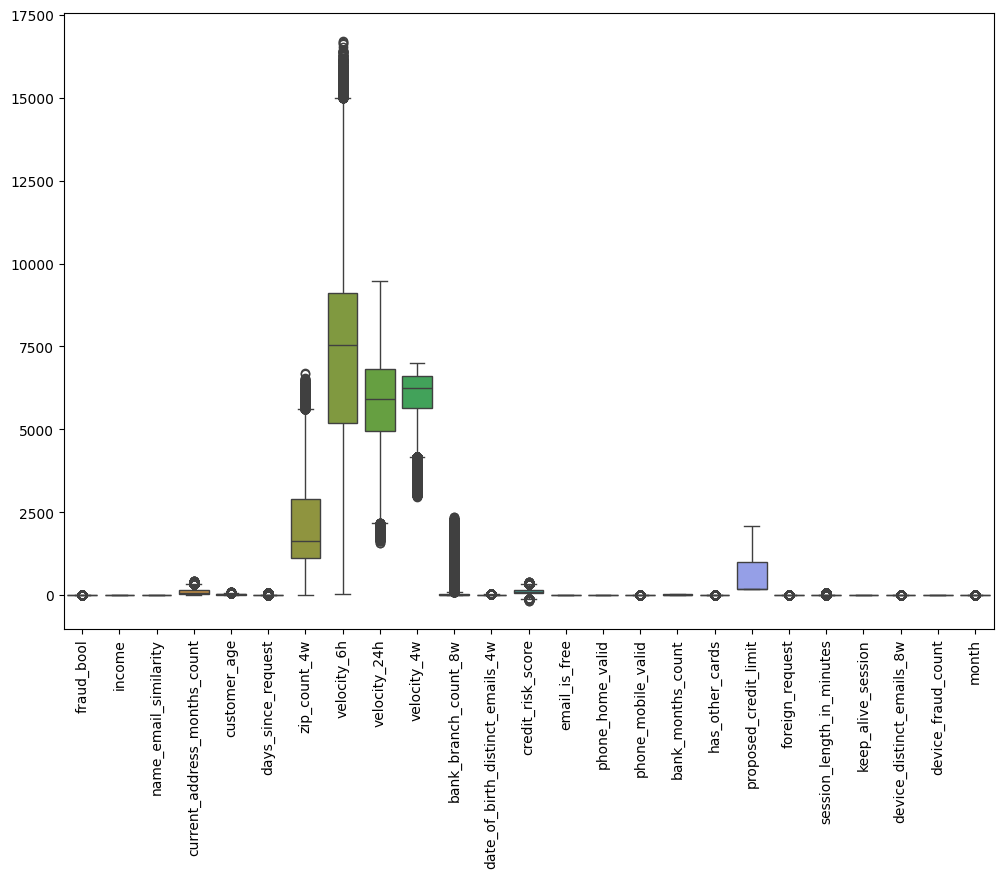

In [16]:
#boxplot pour toutes les variables numériques

import seaborn as sns
import matplotlib.pyplot as plt


plt.figure(figsize=(12, 8))
sns.boxplot(data=df.select_dtypes(include=['float64', 'int64']))
plt.xticks(rotation=90)
plt.show()



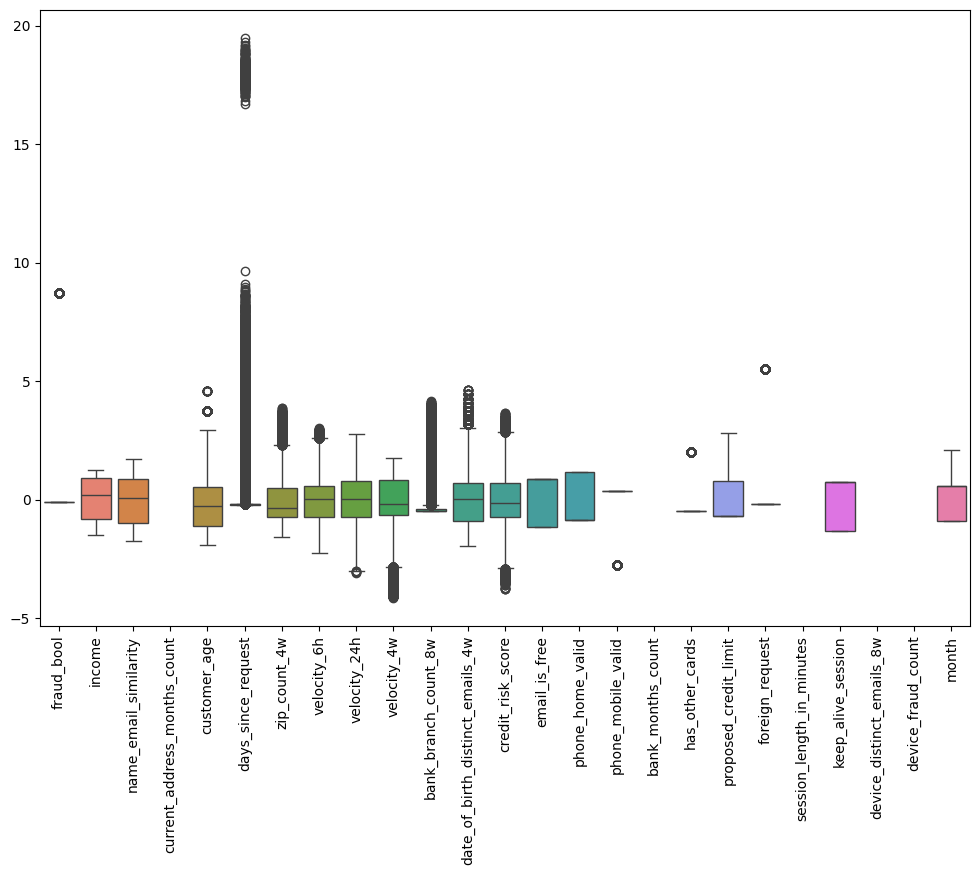

In [ ]:
#les Z-scores pour toutes les colonnes numériques
z_scores = df.select_dtypes(include=['float64', 'int64']).apply(zscore)

# Visualisation des Z-scores
plt.figure(figsize=(12, 8))
sns.boxplot(data=z_scores)
plt.xticks(rotation=90)
plt.show()


Nombre d'occurrence de chaque classe :

In [11]:
data=pd.Series(df['fraud_bool'])

In [12]:
data_count=data.value_counts()

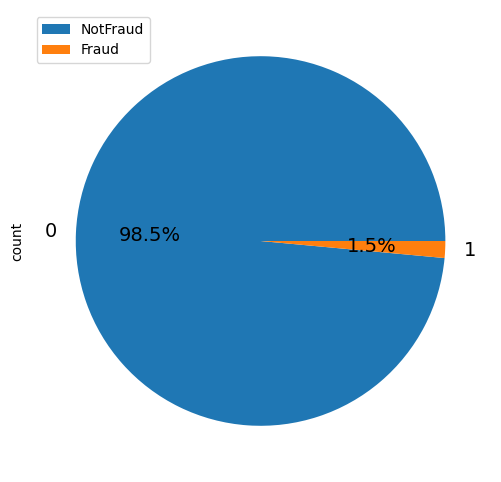

In [13]:
f, axes = plt.subplots(1,1, figsize=(6,6))
data_count.plot(kind='pie',ax=axes, fontsize=14,shadow=False,autopct='%1.1f%%')
plt.legend(loc='upper left',labels=['NotFraud','Fraud'])

## Feature Engineering

In [15]:
#attribution d'un attribut cible à une valeur distincte
#inputs
X = df.drop(['fraud_bool'],axis=1)
#target
y = df['fraud_bool']


## Encodage de données catégorielles

In [16]:
X = pd.get_dummies(X, columns=['employment_status', 'housing_status', 'payment_type'])


In [18]:
X = pd.get_dummies(X, columns=['source'])


KeyError: "None of [Index(['source'], dtype='object')] are in the [columns]"

In [19]:
X = pd.get_dummies(X, columns=['device_os'])



In [20]:
# Remplacer les valeurs manquantes par la moyenne
from sklearn.impute import SimpleImputer

imputer = SimpleImputer(strategy='mean')  # Remplacer par la moyenne
X = imputer.fit_transform(X)


In [20]:
#oversampling, cette méthode est utilisé dans le cas où les données sont déséquilibrés
#augmenter le nombre d'échantillons de la classe minoritaire et équilibrer le jeu de données en utilisant SMOTE
from imblearn.over_sampling import SMOTE
sm = SMOTE(random_state=2)
X_res, y_res = sm.fit_resample(X, y.ravel())

<ipython-input-20-83296352de8c>:5: FutureWarning: Series.ravel is deprecated. The underlying array is already 1D, so ravel is not necessary.  Use `to_numpy()` for conversion to a numpy array instead.
  X_res, y_res = sm.fit_resample(X, y.ravel())
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:474: FutureWarning: `BaseEstimator._validate_data` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation.validate_data` instead. This function becomes public and is part of the scikit-learn developer API.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/utils/_tags.py:354: FutureWarning: The SMOTE or classes from which it inherits use `_get_tags` and `_more_tags`. Please define the `__sklearn_tags__` method, or inherit from `sklearn.base.BaseEstimator` and/or other appropriate mixins such as `sklearn.base.TransformerMixin`, `sklearn.base.ClassifierMixin`, `sklearn.base.RegressorMixin`, and `sklearn.base.OutlierMixin`. From scikit-learn 1.7, not def

## Equlibrer les données

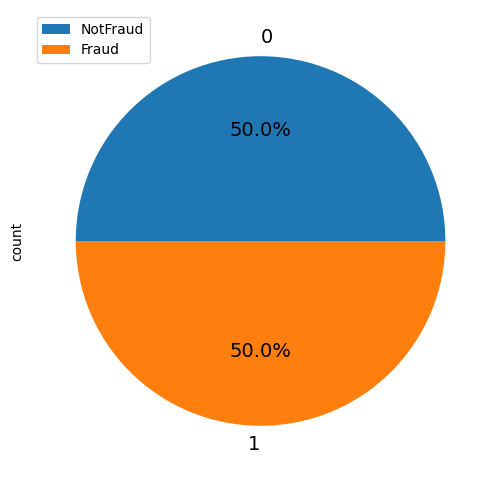

In [21]:
data_count = pd.Series(y_res).value_counts()

fig, ax = plt.subplots(figsize=(6, 6))
data_count.plot(kind='pie', ax=ax, fontsize=14, shadow=False, autopct='%1.1f%%')
plt.legend(loc='upper left', labels=['NotFraud', 'Fraud'])

plt.show()

### Arbre de décision

In [22]:
#attribution d'un attribut cible à une valeur distincte
X = df.drop(columns=["fraud_bool"])
y = df["fraud_bool"]
y

,fraud_bool
0,0
1,0
2,0
3,0
4,0
...,...
999994,0
999995,0
999997,0
999998,0


In [23]:
#Diviser les données en ensembles d'entraînement et de test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

In [21]:
#Codage de données d'entrainement
X_train = pd.get_dummies(X_train, columns=['employment_status', 'housing_status', 'payment_type', 'source','device_os', 'source'])

X_train

NameError: name 'X_train' is not defined

Equlibrer les donner avec la methode RandomUnderSampler

In [27]:
from sklearn.utils.class_weight import compute_sample_weight
sample_weights = compute_sample_weight('balanced', y_train)

In [28]:
from imblearn.under_sampling import RandomUnderSampler

rus = RandomUnderSampler(random_state=42)
X_resampled, y_resampled = rus.fit_resample(X_train, y_train)

print(y_resampled.value_counts())

fraud_bool
0    7678
1    7678
Name: count, dtype: int64


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:484: FutureWarning: `BaseEstimator._check_n_features` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation._check_n_features` instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:493: FutureWarning: `BaseEstimator._check_feature_names` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation._check_feature_names` instead.
  warnings.warn(


Entrainement du modèle

In [29]:
#Créer et entraîner le modèle
from sklearn.tree import DecisionTreeClassifier, plot_tree
random_seed = 42
model = DecisionTreeClassifier(criterion='gini', class_weight='balanced', random_state=random_seed)
# Entraînement/création de l'arbre de décision
model.fit(X_resampled, y_resampled)

DecisionTreeClassifier(class_weight='balanced', random_state=42)

Codage de données de test

In [31]:
X_test = pd.get_dummies(X_test, columns=['employment_status', 'housing_status', 'payment_type', 'source','device_os', 'source'])

X_test

,income,name_email_similarity,current_address_months_count,customer_age,days_since_request,zip_count_4w,velocity_6h,velocity_24h,velocity_4w,bank_branch_count_8w,...,payment_type_AE,source_INTERNET,source_TELEAPP,device_os_linux,device_os_macintosh,device_os_other,device_os_windows,device_os_x11,source_INTERNET,source_TELEAPP
416096,0.6,0.931086,8.0,40,0.028532,761,7355.785914,4809.141069,4912.045843,11,...,False,True,False,True,False,False,False,False,True,False
527591,0.2,0.119438,263.0,20,9.556964,1402,5280.996408,5549.931460,4884.254828,1,...,False,True,False,False,False,True,False,False,True,False
944433,0.9,0.867408,72.0,50,0.016509,949,1023.269905,6337.360671,5976.810615,10,...,False,True,False,True,False,False,False,False,True,False
51260,0.8,0.494878,51.0,20,0.013127,1384,8121.698913,6870.171113,6810.641219,1,...,False,True,False,False,False,True,False,False,True,False
373012,0.9,0.792119,65.0,30,0.005267,875,5934.830816,7364.528575,5525.161999,8,...,False,True,False,False,False,True,False,False,True,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
567021,0.7,0.752979,21.0,40,0.032505,1173,9999.899548,6215.773060,4939.311199,462,...,False,True,False,True,False,False,False,False,True,False
273356,0.4,0.173072,102.0,60,0.020339,1164,5049.573068,2320.575811,5178.588629,16,...,False,True,False,False,False,False,True,False,True,False
651770,0.8,0.143726,93.0,50,0.003621,1314,7518.901326,4698.292068,4306.575123,5,...,False,True,False,False,False,True,False,False,True,False
474531,0.8,0.251159,196.0,40,0.000068,1199,4052.033400,4351.494381,4816.908222,3,...,False,True,False,False,False,False,True,False,True,False


In [32]:
from imblearn.under_sampling import RandomUnderSampler

rus = RandomUnderSampler(random_state=42)
X_test_resampled, y_test_resampled = rus.fit_resample(X_test, y_test)

print(y_resampled.value_counts())

fraud_bool
0    7678
1    7678
Name: count, dtype: int64


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:484: FutureWarning: `BaseEstimator._check_n_features` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation._check_n_features` instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:493: FutureWarning: `BaseEstimator._check_feature_names` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation._check_feature_names` instead.
  warnings.warn(


Evaluation du modèle

In [33]:
#Évaluer le modèle
y_pred = model.predict(X_test_resampled)
accuracy = accuracy_score(y_test_resampled, y_pred)
print(f"Accuracy: {accuracy:.2f}")


Accuracy: 0.76


In [34]:
print("\nClassification Report:")
print(classification_report(y_test_resampled, y_pred))


Classification Report:
              precision    recall  f1-score   support

           0       0.76      0.76      0.76      3351
           1       0.76      0.76      0.76      3351

    accuracy                           0.76      6702
   macro avg       0.76      0.76      0.76      6702
weighted avg       0.76      0.76      0.76      6702



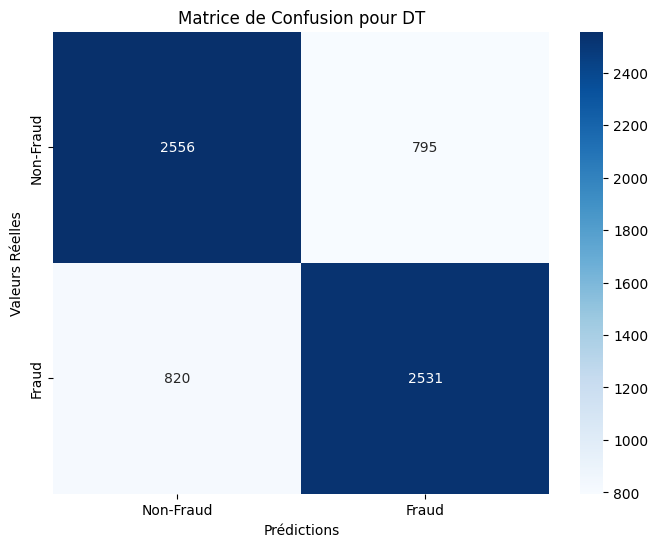

In [39]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# Calcul de la matrice de confusion
conf_matrix = confusion_matrix(y_test_resampled, y_pred)

# Affichage graphique de la matrice de confusion
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=["Non-Fraud", "Fraud"], yticklabels=["Non-Fraud", "Fraud"])
plt.title("Matrice de Confusion pour DT")
plt.xlabel("Prédictions")
plt.ylabel("Valeurs Réelles")
plt.show()